# IMPORT MODULES

In [2]:
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import stats
pd.options.display.float_format = '{:20,.2f}'.format

# LOAD DATA FILES

In [3]:
#open the column description file 
coldesc = pd.read_csv(r'C:\Users\Milo_Sand\Desktop\UdacityProject1Data\columns_description.csv',sep=',')
coldesc.head()

,Unnamed: 0,Table,Row,Description,Special
0,12,application_data,AMT_ANNUITY,Loan annuity,NaN
1,11,application_data,AMT_CREDIT,Credit amount of the loan,NaN
2,13,application_data,AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN
3,10,application_data,AMT_INCOME_TOTAL,Income of the client,NaN
4,120,application_data,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN


In [4]:
#the main data file
df = pd.read_csv(r'C:\Users\Milo_Sand\Desktop\UdacityProject1Data\application_data.csv',sep=',')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50",...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50",...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00",...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
3,100006,0,Cash loans,F,N,Y,0,"135,000.00","312,682.50","29,686.50",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,"121,500.00","513,000.00","21,865.50",...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


# EXPLORE DATA FILES

In [5]:
#dimensions of the column description file
coldesc.shape

(160, 5)

In [6]:
#notice that it explicitly mentions that some colummns are already normalized in the column description file
normalized_cols=coldesc[(coldesc['Special']=='normalized') & (coldesc['Table']=='application_data')]
normalized_cols.iloc[:,1:].head() #ignoring first column -an unnamed column

,Table,Row,Description,Special
10,application_data,APARTMENTS_AVG,Normalized information about building where th...,normalized
11,application_data,APARTMENTS_MEDI,Normalized information about building where th...,normalized
12,application_data,APARTMENTS_MODE,Normalized information about building where th...,normalized
13,application_data,BASEMENTAREA_AVG,Normalized information about building where th...,normalized
14,application_data,BASEMENTAREA_MEDI,Normalized information about building where th...,normalized


In [7]:
df.shape

(307511, 122)

In [8]:
'''look at the target variable distribution, which is whether a customer had diffculty with loan repayment or not. 
There is a large ratio of No's to Yes's.'''

balance = df['TARGET']
balancecounts = balance.groupby(balance)
balancecounts.count()

TARGET
0    282686
1     24825
Name: TARGET, dtype: int64

<Axes: >

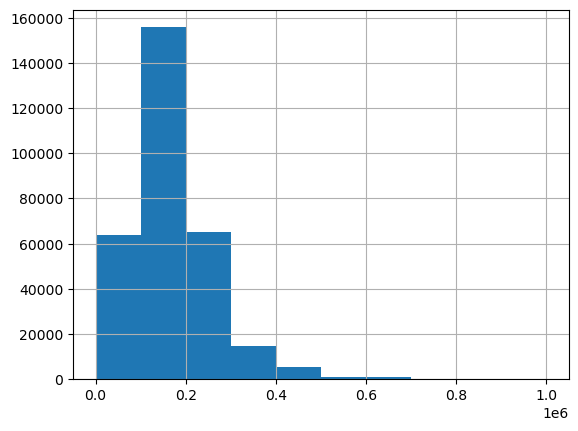

In [9]:
'''investigating one variable that pertains to a question I have.
Does the loan value relative to total income of the customer have any bearing on loan payment difficulty rates? 
First, look at the distribution of income'''
df['AMT_INCOME_TOTAL'].hist(bins=10 , range=[0.0,1000000.0]) #note x axis in exponential format. 

In [10]:
df['AMT_INCOME_TOTAL'].describe()

count             307,511.00
mean              168,797.92
std               237,123.15
min                25,650.00
25%               112,500.00
50%               147,150.00
75%               202,500.00
max           117,000,000.00
Name: AMT_INCOME_TOTAL, dtype: float64

<Axes: >

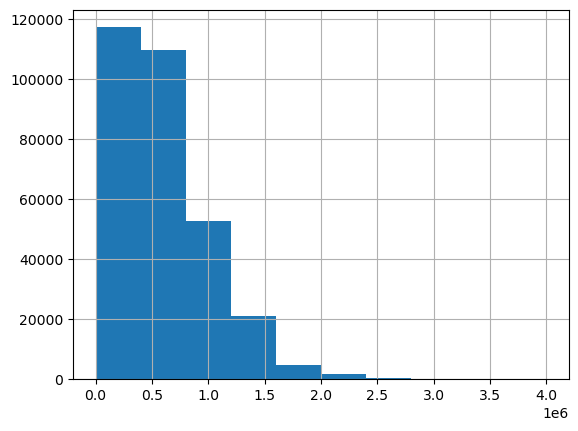

In [11]:
#next look at the distribution of loan values 
df['AMT_CREDIT'].hist(bins=10 , range=[0.0,4000000.0])

In [12]:
#adding an interactive variable poised by my question of whether load value relative to total income plays a part 
df['LOAN_AS_PCT_OF_INCOME']= df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']


Text(0.5, 0, 'Ratio of Loan to Income')

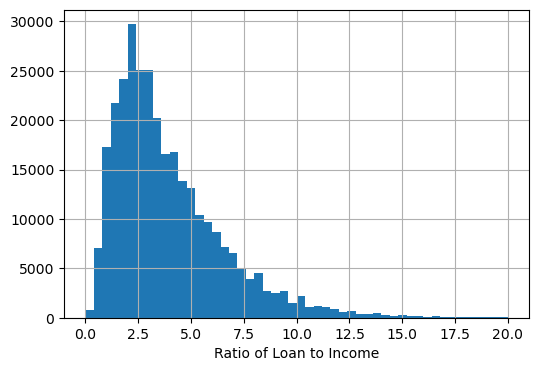

In [13]:
#going to 20 times income. Notice the upper tail gets thin
df['LOAN_AS_PCT_OF_INCOME'].hist(bins=50, range=[0.0,20.0],figsize=(6, 4)).set_xlabel("Ratio of Loan to Income")

# STARTING DATA PREPARATION

In [14]:
#get the numerical variables
num_vars = df.select_dtypes(include=['float','int']).columns
num_vars

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'LOAN_AS_PCT_OF_INCOME'],
      dtype='object', length=107)

In [15]:
#get catagorical variables (confirming no numbers stored as strings)
cat_vars = df.select_dtypes(include=['object']).columns
cat_vars

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [16]:
#take a peek to make sure there are no numbers stored as strings in the categorical variables... 
df[cat_vars].head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
5,Cash loans,M,N,Y,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Other,NaN,NaN,NaN,NaN
6,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,SUNDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
7,Cash loans,M,Y,Y,Unaccompanied,State servant,Higher education,Married,House / apartment,Managers,MONDAY,Other,NaN,NaN,NaN,NaN
8,Cash loans,F,N,Y,Children,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,WEDNESDAY,XNA,NaN,NaN,NaN,NaN
9,Revolving loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,THURSDAY,Electricity,NaN,NaN,NaN,NaN


In [17]:
#take a peek at the numerical varaibles... notice there is an ID column we will need to later delete (the first column)
dfnum = df[num_vars]
dfnum.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LOAN_AS_PCT_OF_INCOME
0,100002,1,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,-9461,-637,...,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00,2.01
1,100003,0,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",0.00,-16765,-1188,...,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,4.79
2,100004,0,0,"67,500.00","135,000.00","6,750.00","135,000.00",0.01,-19046,-225,...,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,2.00
3,100006,0,0,"135,000.00","312,682.50","29,686.50","297,000.00",0.01,-19005,-3039,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.32
4,100007,0,0,"121,500.00","513,000.00","21,865.50","513,000.00",0.03,-19932,-3038,...,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,4.22


Note on the column for number of days since last phone change

Looking at this data, there were no Nulls in the original data for this column. 
But there were also 12% that had a value of zero. Meaning if true then 12% of applicants changed phones the day of applying 
for the loan. Could this be true? I suppose. But it seems very high. Particularly compared to other values. 
But, if we replace the zeros with either the mean or median, we simply move the spike somewhere else. It does not eliminate the spike. 

I referenced details on this column directly on the Kaggle website, which stated that values were valid. So, with that, I decided to keep this as is and let the data speak for itself.  

<Axes: >

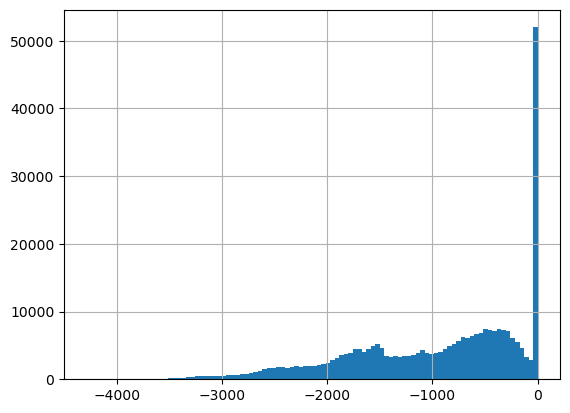

In [18]:
#observe the very large spike at zero days. 
dfnum['DAYS_LAST_PHONE_CHANGE'].hist(bins=100)

In [19]:
# I tried this route then decided against it after referencing the Kaggle website. 
#dfnum['DAYS_LAST_PHONE_CHANGE']=dfnum['DAYS_LAST_PHONE_CHANGE'].replace(0,np.nan)
#dfnum['DAYS_LAST_PHONE_CHANGE']=dfnum['DAYS_LAST_PHONE_CHANGE'].fillna(dfnum['DAYS_LAST_PHONE_CHANGE'].median())
#dfnum['DAYS_LAST_PHONE_CHANGE'].hist(bins=100)

In [20]:
dfnum['DAYS_LAST_PHONE_CHANGE'].describe()

count             307,510.00
mean                 -962.86
std                   826.81
min                -4,292.00
25%                -1,570.00
50%                  -757.00
75%                  -274.00
max                     0.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

Note on the days employed column: this particular column shows days employed as negative numbers, meaning days since the start of employment at that job. But there are many with the value 365243, which is different than the rest of the data. 
Per the description in the column file, this column means the number of days before the application the person started their employment. 
I'm replacing any values of 365243 with np.nan here, then later that will be replaced with the median a few cells down (along with all the other numerical variables). I did not immediately catch this. Otherwise, that means there is set of people working a century in the future! 

In [21]:
dfnum['DAYS_EMPLOYED']=dfnum['DAYS_EMPLOYED'].replace(365243.000000,np.nan) 

In [22]:
#quick peek at correlations. I'm not using this later on as I'm not dropping any numerical columns except the ID column, just wanted to take a quick look. 
dfnum.corr()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,LOAN_AS_PCT_OF_INCOME
SK_ID_CURR,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
TARGET,-0.00,1.00,0.02,-0.00,-0.03,-0.01,-0.04,-0.04,0.08,0.07,...,-0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.00,0.02,-0.01
CNT_CHILDREN,-0.00,0.02,1.00,0.01,0.00,0.02,-0.00,-0.03,0.33,0.06,...,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.04,-0.02
AMT_INCOME_TOTAL,-0.00,-0.00,0.01,1.00,0.16,0.19,0.16,0.07,0.03,-0.01,...,0.00,0.00,-0.00,0.00,0.00,0.00,0.02,0.00,0.01,-0.11
AMT_CREDIT,-0.00,-0.03,0.00,0.16,1.00,0.77,0.99,0.10,-0.06,-0.09,...,0.02,0.03,-0.02,-0.00,0.00,-0.00,0.05,0.02,-0.05,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_WEEK,0.00,0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,-0.00,0.00,...,-0.00,-0.00,0.00,0.00,0.22,1.00,-0.01,-0.02,0.02,-0.01
AMT_REQ_CREDIT_BUREAU_MON,0.00,-0.01,-0.01,0.02,0.05,0.04,0.06,0.08,0.00,-0.02,...,-0.00,0.00,-0.00,-0.00,-0.01,-0.01,1.00,-0.01,-0.00,-0.00
AMT_REQ_CREDIT_BUREAU_QRT,0.00,-0.00,-0.01,0.00,0.02,0.01,0.02,-0.00,-0.01,0.01,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.01,1.00,0.08,0.00
AMT_REQ_CREDIT_BUREAU_YEAR,0.00,0.02,-0.04,0.01,-0.05,-0.01,-0.05,0.00,-0.07,-0.00,...,-0.01,-0.01,-0.01,-0.00,-0.00,0.02,-0.00,0.08,1.00,-0.08


In [23]:
#look at number of nas greater than zero
nas = df.isnull().sum()
nas = nas[nas>0]
nas

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64

In [24]:
#take a quick look at basic stats on the numerical columns 
#suppressing scientific notation as I find this easier to read. 
dfnum[num_vars[:20]].describe() #.apply(lambda s: s.apply('{0:.5f}'.format))

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,"307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,499.00","307,233.00","307,511.00","307,511.00","252,137.00","307,511.00","307,511.00","104,582.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,509.00"
mean,"278,180.52",0.08,0.42,"168,797.92","599,026.00","27,108.57","538,396.21",0.02,"-16,037.00","-2,384.17","-4,986.12","-2,994.20",12.06,1.00,0.82,0.20,1.00,0.28,0.06,2.15
std,"102,790.18",0.27,0.72,"237,123.15","402,490.78","14,493.74","369,446.46",0.01,"4,363.99","2,338.36","3,522.89","1,509.45",11.94,0.00,0.38,0.40,0.04,0.45,0.23,0.91
min,"100,002.00",0.00,0.00,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,"189,145.50",0.00,0.00,"112,500.00","270,000.00","16,524.00","238,500.00",0.01,"-19,682.00","-3,175.00","-7,479.50","-4,299.00",5.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00
50%,"278,202.00",0.00,0.00,"147,150.00","513,531.00","24,903.00","450,000.00",0.02,"-15,750.00","-1,648.00","-4,504.00","-3,254.00",9.00,1.00,1.00,0.00,1.00,0.00,0.00,2.00
75%,"367,142.50",0.00,1.00,"202,500.00","808,650.00","34,596.00","679,500.00",0.03,"-12,413.00",-767.00,"-2,010.00","-1,720.00",15.00,1.00,1.00,0.00,1.00,1.00,0.00,3.00
max,"456,255.00",1.00,19.00,"117,000,000.00","4,050,000.00","258,025.50","4,050,000.00",0.07,"-7,489.00",0.00,0.00,0.00,91.00,1.00,1.00,1.00,1.00,1.00,1.00,20.00


In [25]:
#to save space I looked at a few sets of 20 columns at a time to actually see each column otherwise middle columns don't actually show up. 
c = 20
dfnum[num_vars[c:c+20]].describe()

,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG
count,"307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","307,511.00","134,133.00","306,851.00","246,546.00","151,450.00","127,568.00","157,504.00","103,023.00","92,646.00","143,620.00","152,683.00","154,491.00"
mean,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,0.50,0.51,0.51,0.12,0.09,0.98,0.75,0.04,0.08,0.15,0.23
std,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.21,0.19,0.19,0.11,0.08,0.06,0.11,0.08,0.13,0.10,0.14
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,2.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.39,0.37,0.06,0.04,0.98,0.69,0.01,0.00,0.07,0.17
50%,2.00,2.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.57,0.54,0.09,0.08,0.98,0.76,0.02,0.00,0.14,0.17
75%,2.00,2.00,14.00,0.00,0.00,0.00,0.00,0.00,0.00,0.68,0.66,0.67,0.15,0.11,0.99,0.82,0.05,0.12,0.21,0.33
max,3.00,3.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0.85,0.90,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [26]:
#extracting the boolean columns seperately. 
booleanvars = [col for col in dfnum.columns if set(dfnum[col].unique()).issubset({0,1})]
print(len(booleanvars))
#booleanvars

33


In [27]:
#get the nonboolean set by subtracting the boolean from all the numerical columns 
nonbooleanvars = list(set(num_vars)-set(booleanvars))
print(len(nonbooleanvars))
#nonbooleanvars

74


array([[<Axes: title={'center': 'DEF_60_CNT_SOCIAL_CIRCLE'}>,
        <Axes: title={'center': 'AMT_INCOME_TOTAL'}>]], dtype=object)

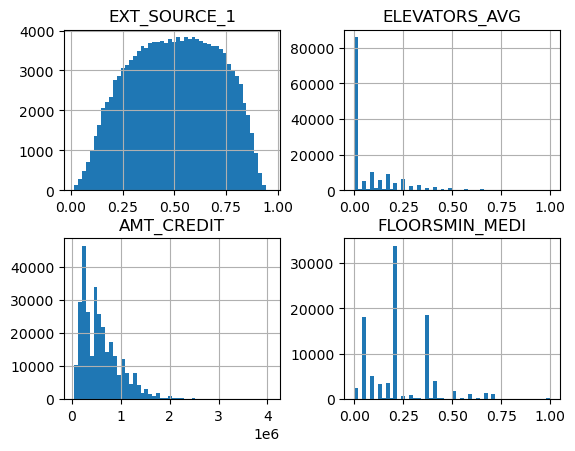

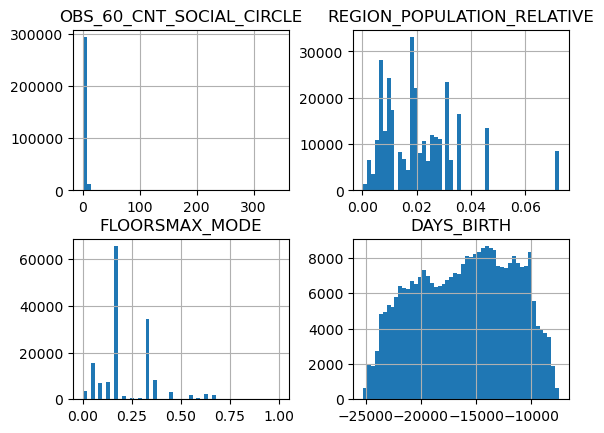

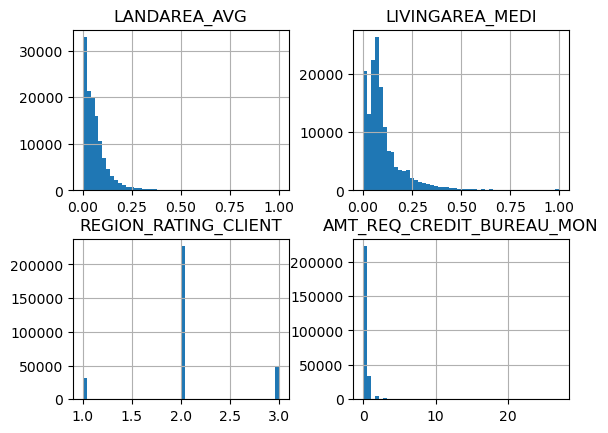

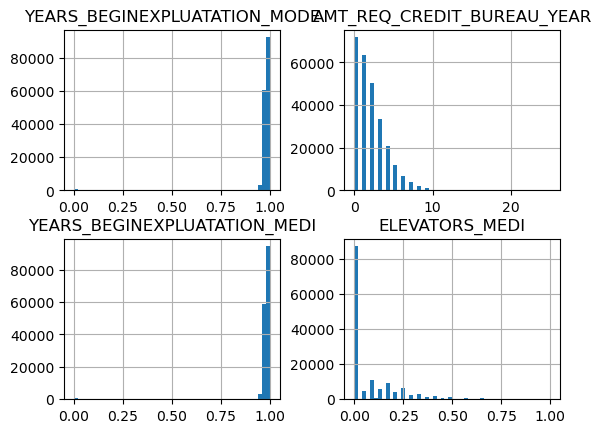

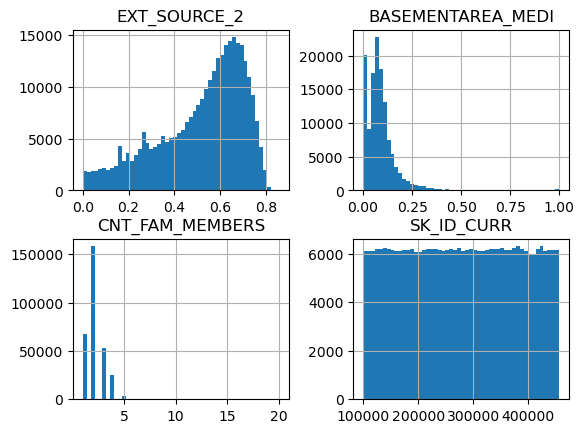

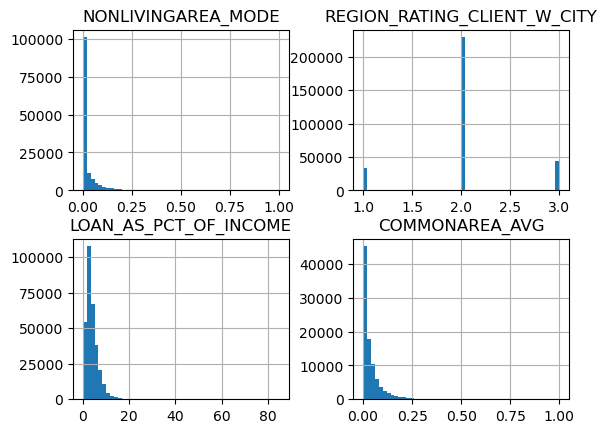

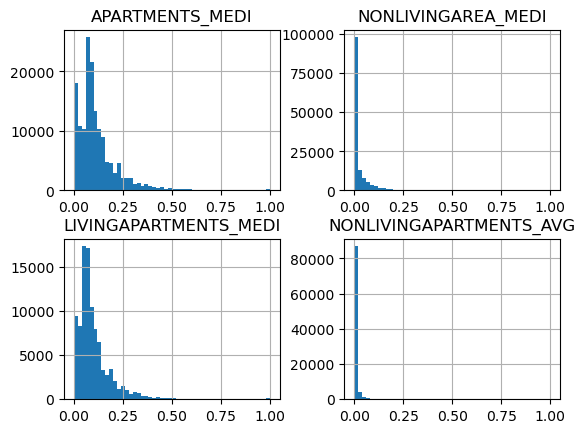

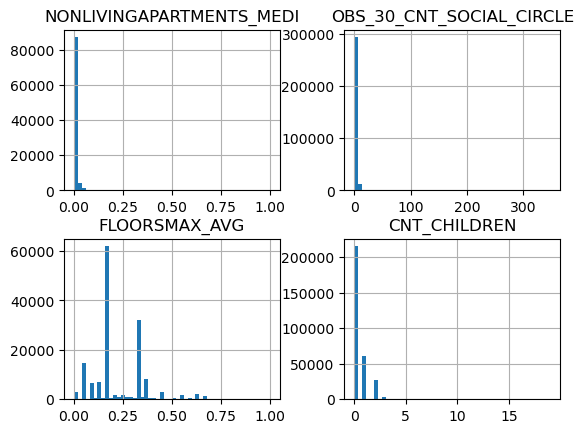

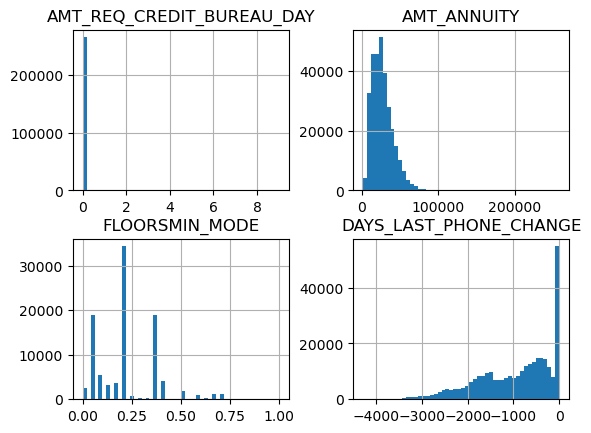

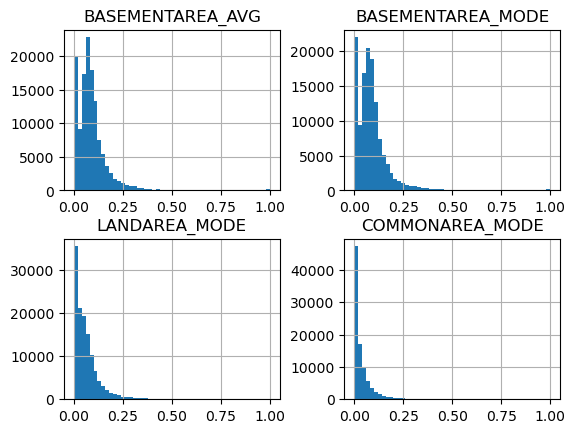

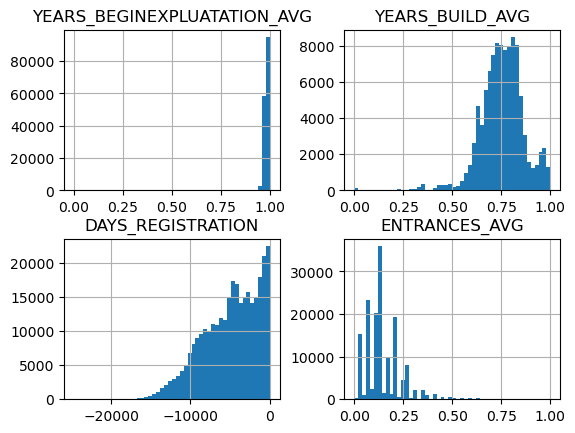

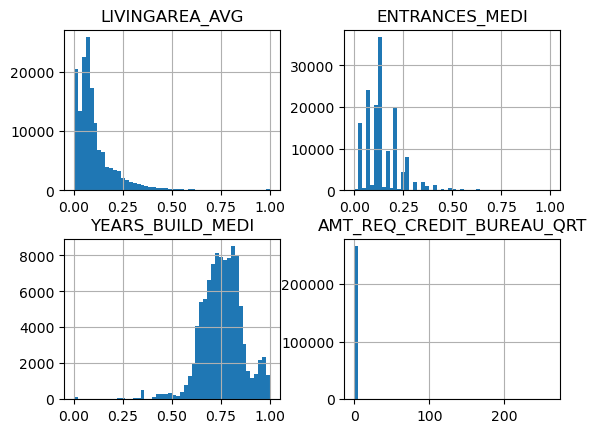

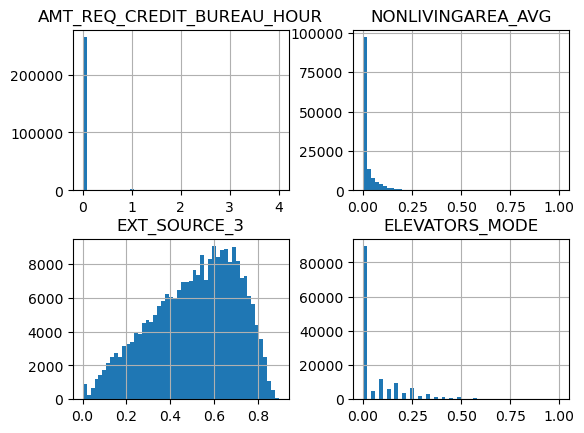

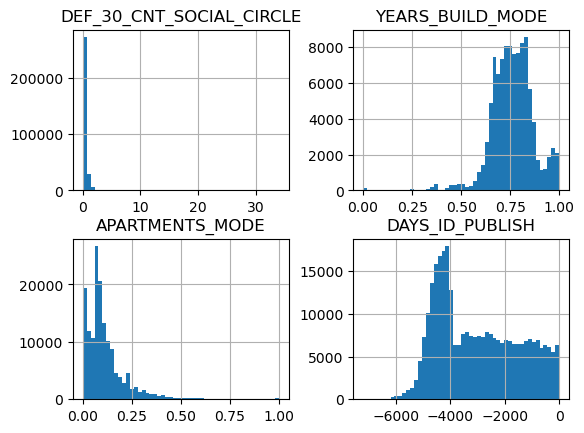

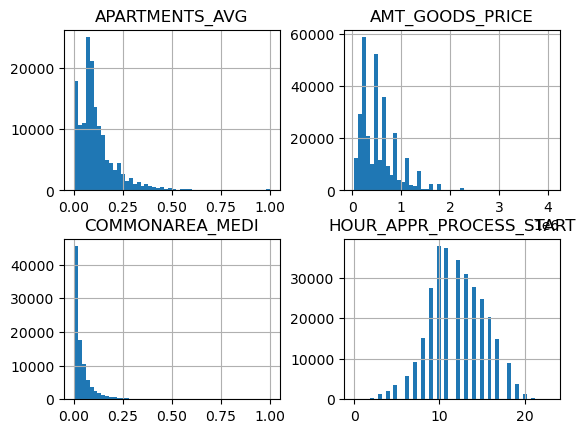

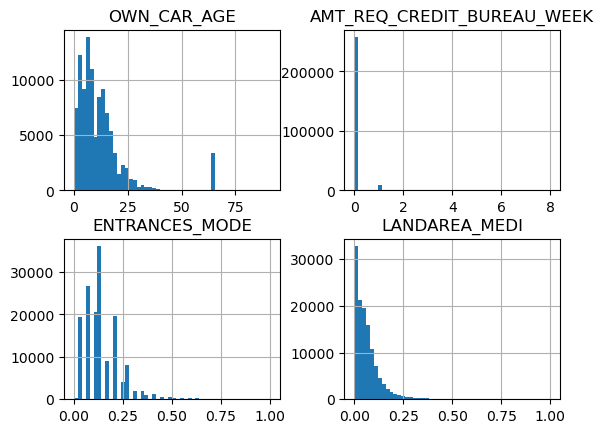

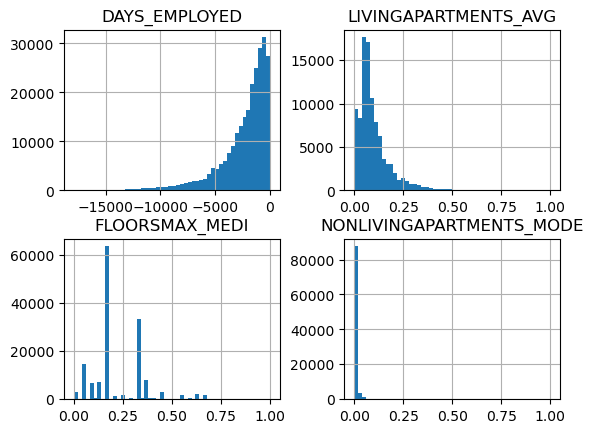

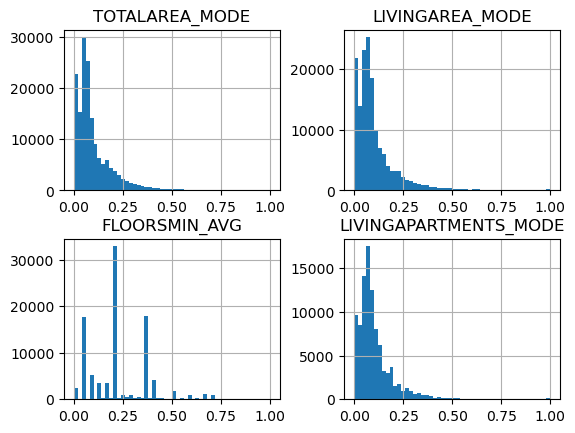

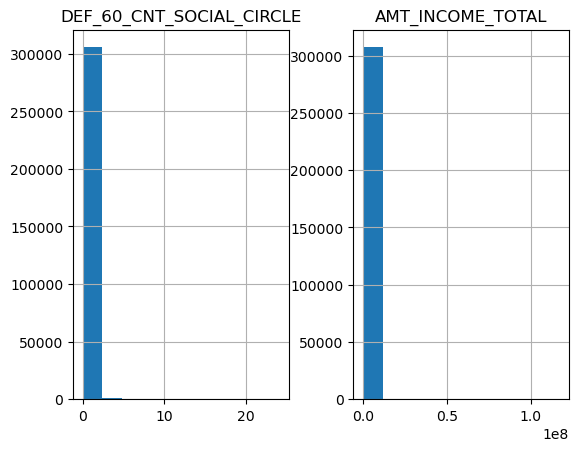

In [28]:
#plot the non boolean numerical variables to look at distributions 
#NOTE some distributions look squished due to the "cookie cutter" method to quickly look at all of them. 
cols = dfnum[nonbooleanvars].columns
#print(len(cols))
#print out histograms of the nonboolean numeric columns in sets of 4 
for i in range(18):
    temp = dfnum[cols[4*i:4*i+4]]
    temp.hist(bins=50)
# #get the remaining leftover 2... 
temp = dfnum[cols[72:74]]
temp.hist()

In [29]:
#create dummy variables for the categorical variable set then drop the original categorical non numerical columns
l = [df[cat_vars]]
for i in range(len(cat_vars)):
    temp = cat_vars[i]
    catout = pd.get_dummies(df[temp],prefix=temp,prefix_sep='_',dummy_na=True,drop_first=True)
    l.append(catout)
dfcat=pd.concat(l,axis=1)
dfcat=dfcat.drop(columns=cat_vars,axis=0)
print(df.shape)
print(dfcat.shape) #expecting an increase due to adding dummies. 

(307511, 123)
(307511, 140)


In [30]:
#fill in nas with median for numerical financial variables since mean often skewed upwards in financial data
fill_median = lambda col:col.fillna(col.median())
df_nonbool = df[nonbooleanvars].apply(fill_median,axis=0)
#Note although some variables were pre normalized, not all were. So normalizing again here. doing it twice makes no difference. 
df_nonbool = (df_nonbool-df_nonbool.mean())/df_nonbool.std()

#fill mode for booleans as mean or median make no sense as discussed in the course
fill_mode = lambda col:col.fillna(col.mode())
df_bool = df[booleanvars].apply(fill_mode,axis = 0) 

#looking at shapes. 
print(df.shape) #original dataframe
print(dfcat.shape) #will add more columns
print(df_nonbool.shape)
print(df_bool.shape)

(307511, 123)
(307511, 140)
(307511, 74)
(307511, 33)


In [31]:
#sanity check
x = 140+74+33
x

247

In [32]:
#combining the categorical, boolean and non boolean variables into a new dataframe we can use.
new_df = pd.concat([dfcat,df_nonbool,df_bool],axis=1)
new_df = new_df.drop('SK_ID_CURR',axis=1) #dropping the ID column
new_df.head()

,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan,FLAG_OWN_CAR_Y,FLAG_OWN_CAR_nan,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_nan,NAME_TYPE_SUITE_Family,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,False,False,True,False,False,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
1,False,False,False,False,False,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0
2,True,False,True,False,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,False,False,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
4,False,False,True,False,False,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#sanity check to see if any remaining NULLS. We're all good.  
nas =new_df.isna().sum()
nas[nas>0]

Series([], dtype: int64)

In [34]:
#definition to make a more balance set as there are many more non defaults than defaults in the target variable 
#question? should it be 50/50? no. accuracy rates suffer since there are so many more non defaults than defaults. 

def pull_ratioed_subset(targetvariable,df,samplesize=10000,nomultiplier=2):
    """
    this function finds out how many values are yes vs no of the target variable and splits them into 2 dataframes.
    Since this data has many more non defaulting customers, there are many more "nos" than "yes's". This allows 
    the program to experiment with ratios of no counts to to yes counts then add them to a new shuffled dataframe

    :param targetvariable: the y value of the dataframe
    :param df: the input dataframe to use
    :param samplesize: how many rows to grab from the target category with less rows. In this case, the nos. Defaults at 10K.
    Note that the no's had a bit over 24,800 total. 
    :param multiplier: what is the ratio of rows used from the target variable category with more rows (in this case the no's) compared to the 
    rows used from the target variable category with less rows (in this case the yes's). This defaults to 2. So it's a 2 to 1 ratio by default.
    :return: a shuffled, concatenated ratioed dataset 
    """ 
    dfyes = df[df[targetvariable]==1]
    dfno = df[df[targetvariable]==0]
    dfy = dfyes.sample(n=samplesize,random_state=42)
    dfn = dfno.sample(n=round(samplesize*(nomultiplier),0),random_state=42)
    dfout = pd.concat([dfy,dfn],axis=0)
    #shuffle rows 
    dfout = dfout.sample(frac=1).reset_index(drop=True)
    
    return dfout 

In [35]:
#printing the shape with original number of rows
print(new_df.shape)
#putting the dataframe into the ratio function created above
dfout = pull_ratioed_subset(targetvariable='TARGET',df=new_df,samplesize=15000,nomultiplier=7)
X = dfout
X = X.drop('TARGET',axis=1) #the target variable
y = dfout['TARGET']
#print out the new shape. Since the ratio we used is 7 to 1, and the samplesize is 15K, we should expect 120K rows, which is what we see
X.shape

(307511, 246)


(120000, 245)

In [36]:
print(dfout['TARGET'].sum())

15000


In [37]:
#looking at normalized data
X.describe()

,EXT_SOURCE_1,ELEVATORS_AVG,AMT_CREDIT,FLOORSMIN_MEDI,OBS_60_CNT_SOCIAL_CIRCLE,REGION_POPULATION_RELATIVE,FLOORSMAX_MODE,DAYS_BIRTH,LANDAREA_AVG,LIVINGAREA_MEDI,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00",...,"120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00","120,000.00"
mean,-0.02,-0.01,-0.00,-0.00,0.00,-0.01,-0.00,0.02,-0.01,-0.00,...,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00
std,1.01,0.99,0.99,0.99,0.96,1.00,0.99,1.00,0.98,0.99,...,0.00,0.06,0.06,0.03,0.10,0.02,0.09,0.02,0.02,0.02
min,-3.51,-0.37,-1.38,-2.33,-0.59,-1.49,-1.84,-2.10,-1.06,-1.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.01,-0.37,-0.82,-0.08,-0.59,-0.79,-0.26,-0.82,-0.14,-0.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.01,-0.37,-0.21,-0.08,-0.59,-0.15,-0.26,0.09,-0.14,-0.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.01,-0.37,0.52,-0.08,0.25,0.56,-0.26,0.85,-0.14,-0.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,3.18,9.63,8.57,8.48,11.61,3.73,7.63,1.92,17.99,11.21,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [38]:
#for reference
X.columns[150:]

Index(['REGION_RATING_CLIENT', 'AMT_REQ_CREDIT_BUREAU_MON',
       'YEARS_BEGINEXPLUATATION_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'EXT_SOURCE_2',
       'BASEMENTAREA_MEDI', 'CNT_FAM_MEMBERS', 'NONLIVINGAREA_MODE',
       'REGION_RATING_CLIENT_W_CITY', 'LOAN_AS_PCT_OF_INCOME',
       'COMMONAREA_AVG', 'APARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_AVG',
       'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_ANNUITY',
       'FLOORSMIN_MODE', 'DAYS_LAST_PHONE_CHANGE', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'LANDAREA_MODE', 'COMMONAREA_MODE',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'DAYS_REGISTRATION',
       'ENTRANCES_AVG', 'LIVINGAREA_AVG', 'ENTRANCES_MEDI', 'YEARS_BUILD_MEDI',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'NONLIVINGAREA_AVG', 'EXT_SO

# STARTING THE MACHINE LEARNING 

In [39]:
#split into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,random_state=42)


In [40]:
#trying 2 concurrent models. a logistic regression model and later a random forest classifier model. 
#going into this, I didn't know which one would perform better or if they were both about the same. 

logreg = LogisticRegression(random_state=42,max_iter=1000) #NOTE: added max iterations as not having this resulted in the suggestion to do so. 
logreg.fit(X_train,y_train)
y_pred_train = logreg.predict(X_train)
pred_probabilities_train = logreg.predict_proba(X_train)

y_pred = logreg.predict(X_test)
pred_probabilities = logreg.predict_proba(X_test)

prob = pd.DataFrame(pred_probabilities)



In [41]:
#get the model odds of default versus not. 
print('default:',prob[1].mean(),'non default:',prob[0].mean())

default: 0.12454576497098203 non default: 0.875454235029018


In [42]:
#accuracy of the logistic regression model
score= accuracy_score(y_test,y_pred)
print('Accuracy:',score)


Accuracy: 0.8745277777777778


In [43]:
#now work on random forest 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
pred_probabilities_train = rf.predict_proba(X_train)

y_pred = rf.predict(X_test)

pred_probabilities = rf.predict_proba(X_test)

prob = pd.DataFrame(pred_probabilities)



In [44]:
#get the model odds of default versus not for the Random Forest Classifier. 
print('default:',prob[1].mean(),'non default:',prob[0].mean())

default: 0.13479694444444446 non default: 0.8652030555555557


In [45]:
#accuracy of the  random forest classification model
score= accuracy_score(y_test,y_pred)
print('Accuracy:',score)


Accuracy: 0.8733611111111111


# ASKING AND ANSWERING SOME QUESTIONS

The random forest model has a slightly higher accuracy rate than the logistic regression model, so we'll use the former to answer some questions, starting in this section


First question: what are some variables that the model considered important? 

Second Question: how did the interactive variable we added end up in the model's importance? 

Third question: what are the odds of a customer having challenges in repaying the loan? 

In [58]:
#NOTE: answering the third question first since it is 1 line. 
print('Answer to the third question: Odds of challenges in repayment:',prob[1].mean()) 

Answer to the third question: Odds of challenges in repayment: 0.13479694444444446


In [47]:
#Let's go back to look at the first 2 questions and how the model ranked importance of features. We'll print out the top 10 feature weights. 

feature_importances = list(zip(X_train.columns.tolist(), rf.feature_importances_))

df_feature_importances = pd.DataFrame(feature_importances, columns=['Feature', 'Model Weight'])
filtered_features =df_feature_importances[df_feature_importances['Model Weight']>0] #screening out the lower rated features 
sorted_features=filtered_features.sort_values(['Model Weight'],ascending=[False])
top10 = sorted_features[:10] #looking at the top 10 

top10 = top10.reset_index()
top10.index += 1 #make the first number 1 since we're looking at a top 10.
top10[['Feature','Model Weight']]

,Feature,Model Weight
1,EXT_SOURCE_2,0.05
2,EXT_SOURCE_3,0.05
3,DAYS_BIRTH,0.03
4,DAYS_ID_PUBLISH,0.03
5,DAYS_REGISTRATION,0.03
6,LOAN_AS_PCT_OF_INCOME,0.03
7,AMT_ANNUITY,0.03
8,DAYS_LAST_PHONE_CHANGE,0.03
9,DAYS_EMPLOYED,0.03
10,AMT_CREDIT,0.03


It looks like the loan as a percentage of income weighted in at number 6 

Let's look more at the following 4 features out of the top 10 items listed above in more detail. 

1) The top variable is - per the column description file - normalized data from an external source called EXT_SOURCE_2. 
Given that the model rated this the most important feature, and given that almost any lending institute is going to run a credit report on 
any applicant, along with the fact that credit bureau models tend to be predictive (otherwise why use them?),
I suspect that these are from credit bureaus. The shape of the curve suggests this.  
 
2) The next feature is DAYS_BIRTH. Keep in mind that this feature is in negative numbers so the lower the number, the more days since birth. 

3) The next feature I want to look at is the added interactive variable for the ratio of the loan relative to income called LOAN_AS_PCT_OF_INCOME. 

4) The final variable to look at is one I did not even consider until looking at this data. 
The number of days since the applicant got a new phone called DAYS_LST_PHONE_CHANGE

Now let's look at some charts and data. 

In [48]:
#first, looking at these 4
#looking at the stats for the 4 items mentioned above
let_us_look_at_these = ['EXT_SOURCE_2',
 'DAYS_BIRTH',
 'LOAN_AS_PCT_OF_INCOME',
 'DAYS_LAST_PHONE_CHANGE'
]
new_df[let_us_look_at_these].describe() 

,EXT_SOURCE_2,DAYS_BIRTH,LOAN_AS_PCT_OF_INCOME,DAYS_LAST_PHONE_CHANGE
count,"307,511.00","307,511.00","307,511.00","307,511.00"
mean,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.70,-2.11,-1.47,-4.03
25%,-0.64,-0.84,-0.72,-0.73
50%,0.27,0.07,-0.26,0.25
75%,0.78,0.83,0.45,0.83
max,1.78,1.96,30.03,1.16


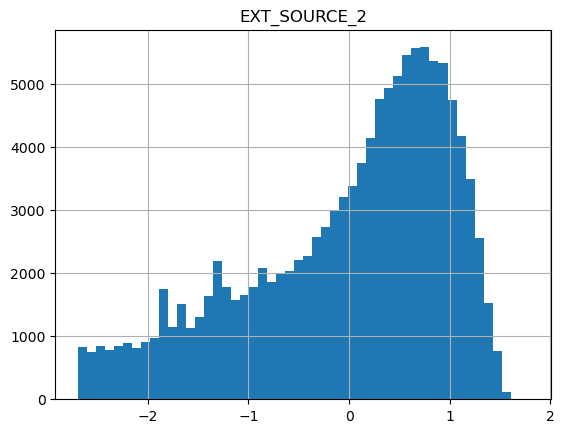

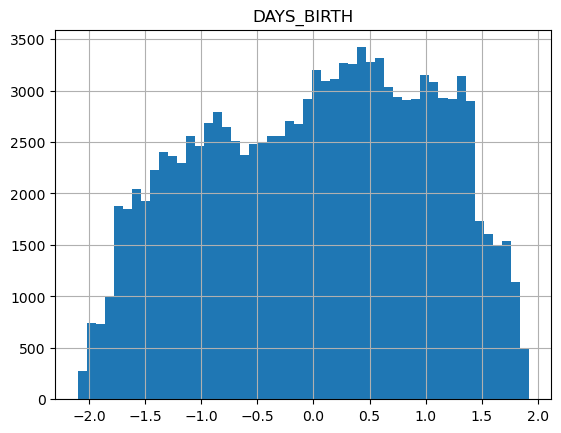

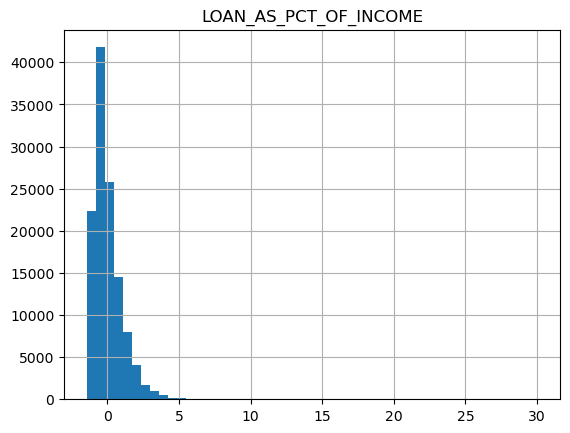

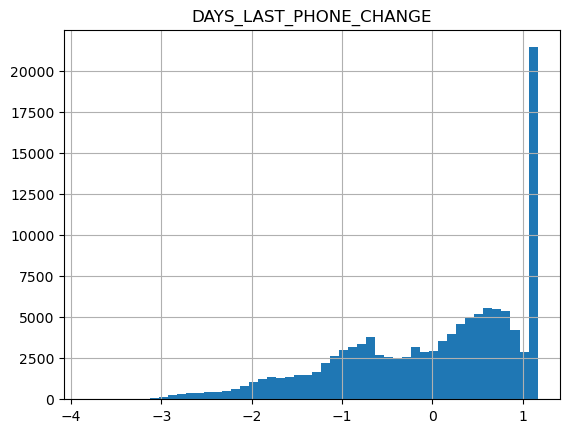

In [49]:
#looking at the normalized distributions of the 4 items mentioned above
let_us_look_at_these = ['EXT_SOURCE_2',
 'DAYS_BIRTH',
 'LOAN_AS_PCT_OF_INCOME',
 'DAYS_LAST_PHONE_CHANGE'
]


for i in range(len(let_us_look_at_these)):
    #print(i,top10[i])
    temp = X[[let_us_look_at_these[i]]]
    temp.hist(bins=50)


In [50]:
#making a copy of the X_test set from the Random Forest model 
Xcopy = X_test.copy()
Xcopy = Xcopy.reset_index()
#adding probabilities to Xcopy
Xcopy['odds_of_payment_difficulty']=prob[1]

In [51]:
#this section adds some quintiles to the top 10 so we can take a look at potential trends. 
lookat = ['EXT_SOURCE_2', 
 'DAYS_BIRTH', 'LOAN_AS_PCT_OF_INCOME',
 'DAYS_LAST_PHONE_CHANGE']
newcollist =[]
newranklist =[]
for i in range(len(lookat)):
    try:
        Xcopy[f'quintiles_{let_us_look_at_these[i]}']= pd.qcut(Xcopy[let_us_look_at_these[i]], 5, 
                            labels = False) 
        newcollist.append(f'quintiles_{let_us_look_at_these[i]}')
    except Exception as e:
        print("exception of ",e)

 

Let's take a look at the odds by quintile for each of the 4 categories 

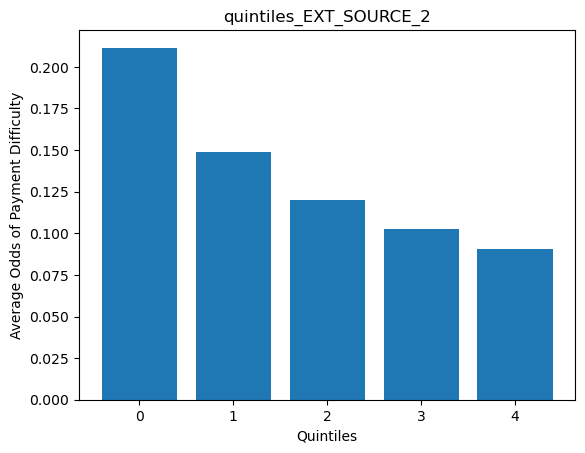

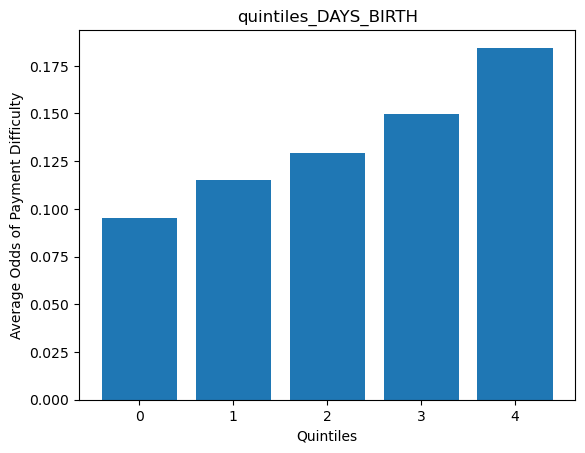

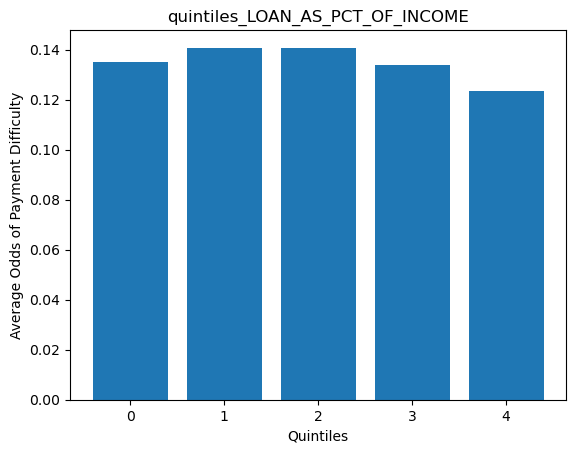

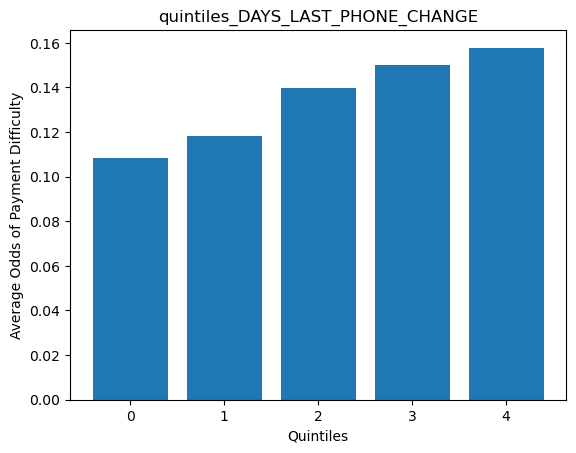

In [52]:
i=0
for i in range(len(newcollist)):
    dfg = Xcopy.groupby([newcollist[i]])['odds_of_payment_difficulty'].mean()
    x =dfg.index 
    y = dfg.values 
    
    plt.bar(x, y)
    plt.title(f'{newcollist[i]}')
    plt.xlabel('Quintiles')
    plt.ylabel('Average Odds of Payment Difficulty')
    plt.show()

Observations on the quintiles from above: 

The quintiles for the 'EXT_SOURCE_2' column show a clear linead trend with lower odds of payment difficuly the higher the value. 

The quintiles for the 'DAYS_BIRTH' column show an opposite linear trend than the first column. The lower the age, the higher the odds of repayment difficulties. 

The quintiles for the 'LOAN_AS_PCT_OF_INCOME' do not show a clear linear trend. While the first 3 have a clear upward pattern, it then declines for the last 2. 

The quintiles for the 'DAYS_LAST_PHONE_CHANGE' also show a clear linear trend. The shorter the length of ownership of the phone, the higher odds of payment difficulty with the loan. 

In [53]:
l2 = let_us_look_at_these
for j in range(len(newcollist)):
    l2.append(newcollist[j])
    


In [54]:
#looking at average income by age brackets. There is not a clear linear trend here. 
df_income_age = new_df[['AMT_INCOME_TOTAL','DAYS_BIRTH']]
df_income_age = df_income_age[(np.abs(stats.zscore(df_income_age)) <= 3).all(axis=1)]
df_income_age['age_bins'] = pd.cut(x=df_income_age['DAYS_BIRTH'], bins=[-2.5,-2,-1.5,-1,0,0.5,1,1.5,2])
df_income_age.groupby(['age_bins'])['AMT_INCOME_TOTAL'].mean()



age_bins
(-2.5, -2.0]                  -0.22
(-2.0, -1.5]                  -0.14
(-1.5, -1.0]                  -0.06
(-1.0, 0.0]                    0.02
(0.0, 0.5]                     0.04
(0.5, 1.0]                     0.03
(1.0, 1.5]                    -0.01
(1.5, 2.0]                    -0.09
Name: AMT_INCOME_TOTAL, dtype: float64

In [55]:
df_income_age.groupby(['age_bins'])['AMT_INCOME_TOTAL'].count()

age_bins
(-2.5, -2.0]     1210
(-2.0, -1.5]    23400
(-1.5, -1.0]    38185
(-1.0, 0.0]     84090
(0.0, 0.5]      50996
(0.5, 1.0]      48196
(1.0, 1.5]      44641
(1.5, 2.0]      16339
Name: AMT_INCOME_TOTAL, dtype: int64

In [56]:
#let's look at average credit scores by age bracket. There is a clear trend that seems to peak somewhere in middle age, then 
df_creditscore_age = new_df[['EXT_SOURCE_2','DAYS_BIRTH']]

df_creditscore_age = df_creditscore_age[(np.abs(stats.zscore(df_creditscore_age)) < 5).all(axis=1)]
#cutting into 10 groups
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8,9,10]
df_creditscore_age['age_bins']= pd.cut(df_creditscore_age['DAYS_BIRTH'], bins=len(age_labels), labels=age_labels, ordered=True)

creditbyage = df_creditscore_age.groupby(['age_bins'])['EXT_SOURCE_2'].mean()

#order from older to younger due to values being stored as negatives.
creditbyage

age_bins
0                   -0.01
1                   -0.00
2                    0.05
3                    0.11
4                    0.12
5                    0.11
6                    0.07
7                    0.00
8                   -0.09
9                   -0.23
10                  -0.50
Name: EXT_SOURCE_2, dtype: float64

The age by income trend seems more U shaped than linear with the peak being somewhere in the middle. 

Let's plot the Credit Score by Age Brackets

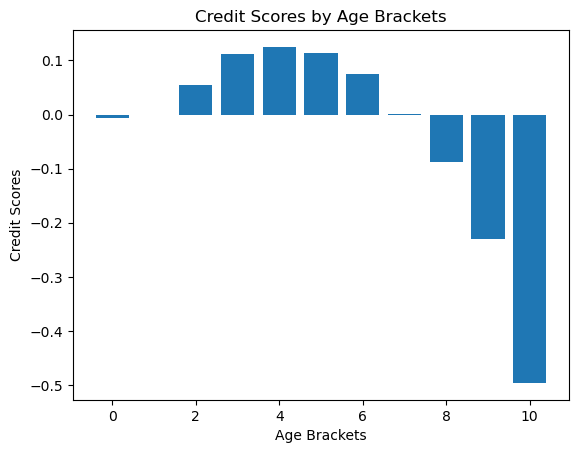

In [57]:
x =creditbyage.index 
y = creditbyage.values 
plt.bar(x, y)
plt.title(f'Credit Scores by Age Brackets')
plt.xlabel('Age Brackets')
plt.ylabel('Credit Scores')
plt.show()

# Summary

While there are many features in this model, after some investigation, the fields I was interested in were the 'EXT_SOURCE_2' (credit bureau), 'DAYS_BIRTH' (age in days), 'DAYS_LAST_PHONE_CHANGE' (days of phone ownership) and the interactive variable I added 'LOAN_AS_PCT_OF_INCOME'. 
The first 3 all show a clear linear trend based on quintiles. 

The 'LOAN_AS_PCT_OF_INCOME' shows a potentially more complex trend in that it is not linear throughout despite being one of the more important variables according to the Random Forest Model.  

Looking at a second chart with age vs. credit scores gives some insight into the trend by age in that, when considering a set of approved customers, all other things being equal, an older customer would on average have a longer credit history, which is considered a positive input to someone's credit score. 

Finding the variable about length of phone ownership was not something I considered before looking at this data. And I used to work in credit in the past. 

Overall, running 2 models with the same data came out with surprising close odds at about 13% chance of any customer having difficulties paying back the loan. 


